100%|██████████| 35000/35000 [01:50<00:00, 315.88it/s]


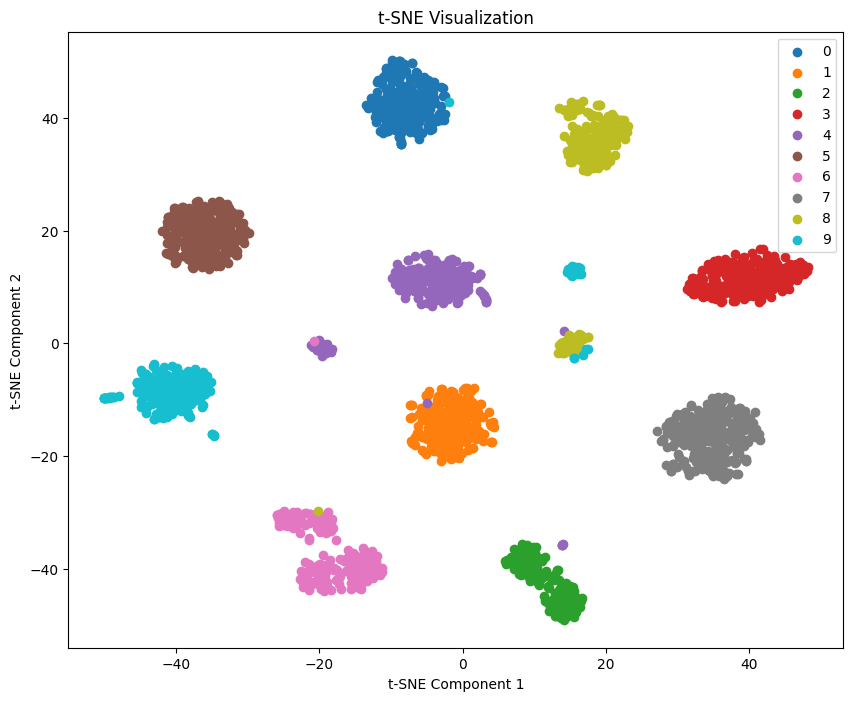

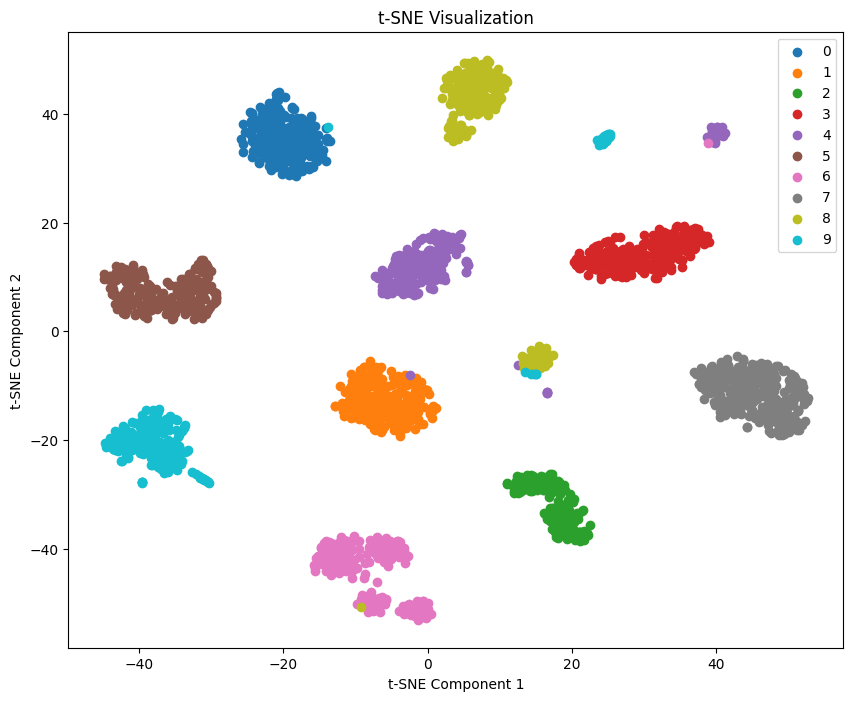

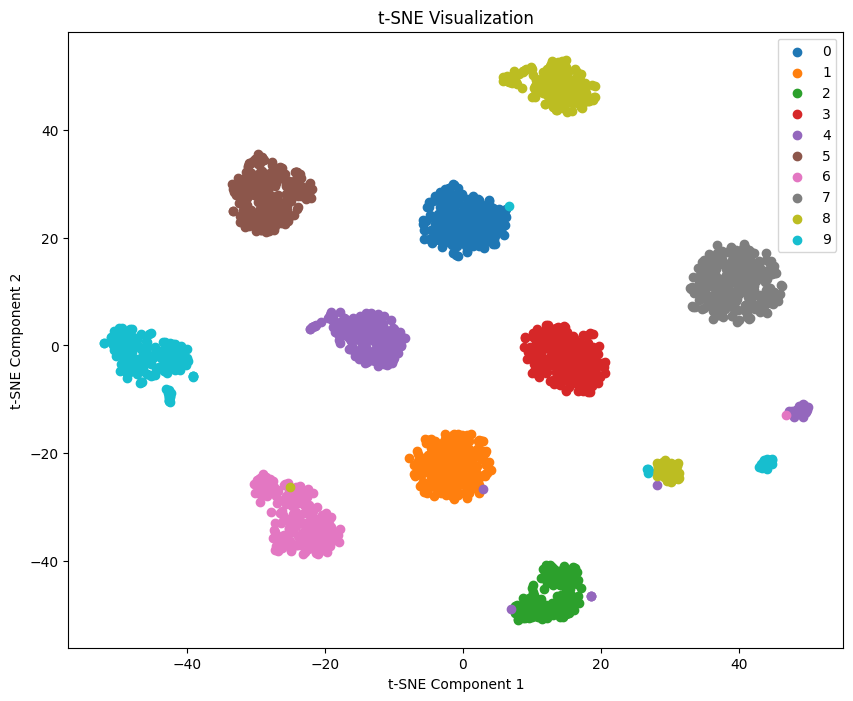

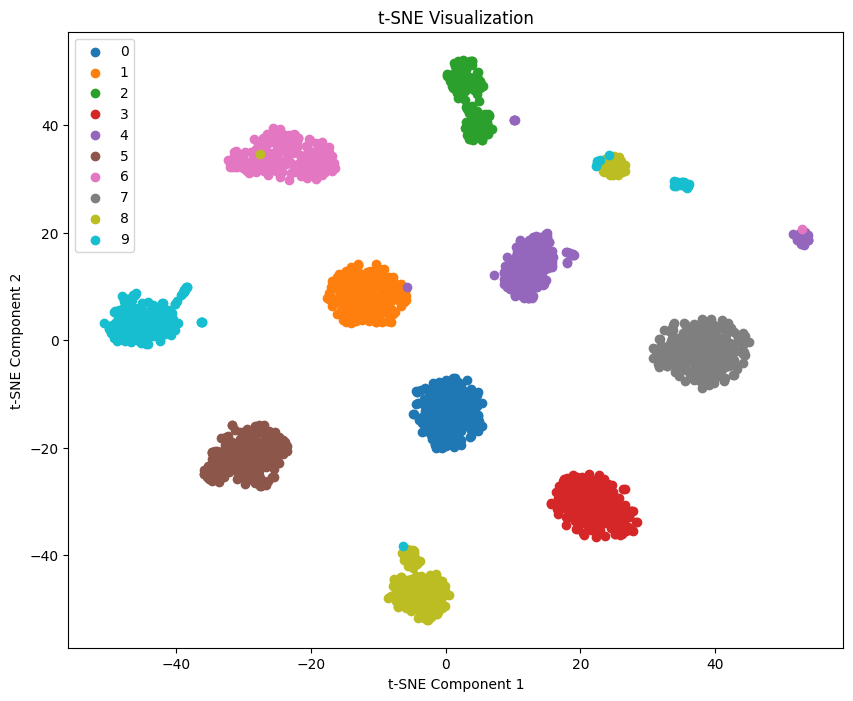

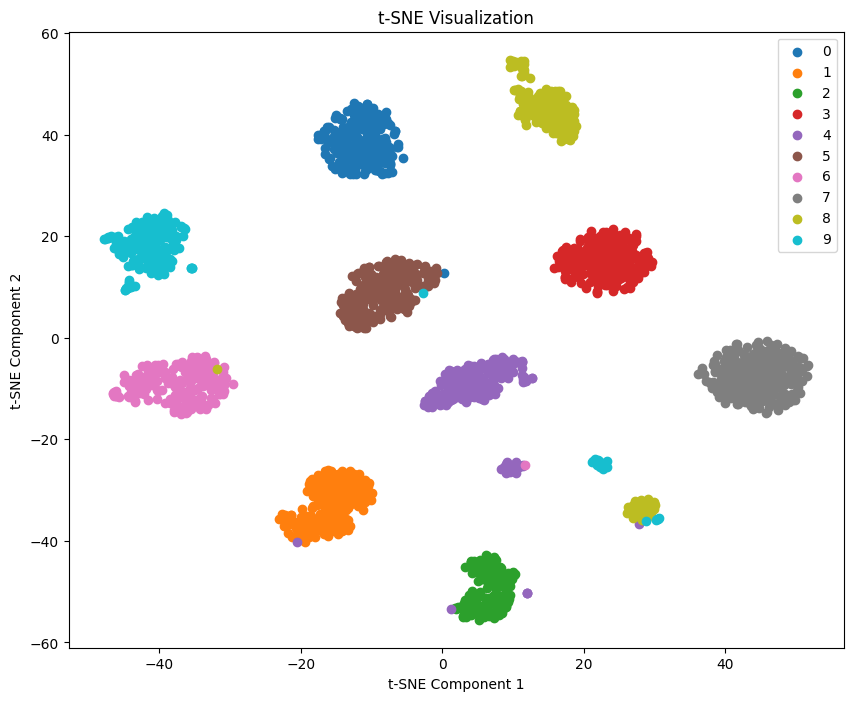

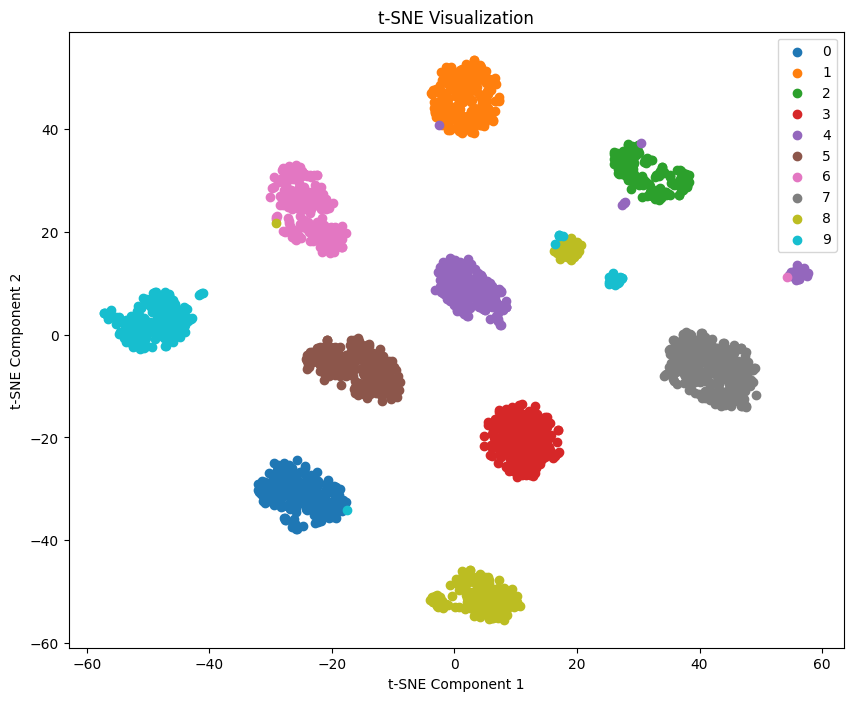

In [30]:
from dataloader_ds import AudioDataset, load_wav
from tqdm import tqdm
from torch.utils.data import DataLoader
from models import Conformer_SER_SSL, SSL_SER_Config, Downstream_model
from torch.nn import functional as F
import torch.nn as nn
import torch
import json
import argparse
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
device = 'cuda'


batches = [16,32,64,128,256,512]
for xyz in batches:
    #remove _200 to get 100 epochs performance
    load_dir = "./logs/log_" + str(xyz) + "/" + "checkpoint_200.pth"
    dev = pd.read_csv("train.csv")
    device = 'cuda'
    with open("config.json", "r", encoding='utf8') as f:
        cfg_dict = json.load(f)
    cfg = SSL_SER_Config(cfg_dict)
    ssl = Conformer_SER_SSL(cfg).to(device)
    ssl.load_state_dict(torch.load(load_dir))
    dev = pd.read_csv("train.csv")
    embs = []
    labels = []
    with torch.no_grad():
        for point in tqdm(range(len(dev))):
            path = dev['Path'][point]
            label = dev['Label'][point]
            if label<10:
                audio, sampling_rate = load_wav(path)
                emb = ssl.get_embedding(torch.tensor(audio, device=device).unsqueeze(0)).squeeze(0).detach().cpu().numpy()
                embs.append(emb)
                labels.append(label)
    embs, labels = np.array(embs), np.array(labels)
    embs_ten = []
    labels_ten = []
    for i in range(len(embs)):
        if labels[i]<10:
            embs_ten.append(embs[i])
            labels_ten.append(labels[i])
    embs_ten, labels_ten = np.array(embs_ten), np.array(labels_ten)


    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(embs_ten)

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(labels_ten)
    for label in unique_labels:
        indices = labels_ten == label
        plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=label)

    plt.legend()
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.savefig("visual/" + str(xyz) + '.png', dpi=300)

# plt.show()

  